In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
brian_df = pd.read_csv('data_mask.csv')
brian_df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [4]:
#Ok la ruta de la imagen para el paciente 1

first_patient_image = brian_df['image_path'][0]

In [5]:
first_patient_image

'TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif'

In [6]:
#Vamos a hacer un gráfico interactivo de cuantos hay en el 0 y en el 1
import plotly.graph_objects as go

#Vamos a representar los ejes
x=brian_df['mask'].value_counts().index
y = brian_df['mask'].value_counts()

In [7]:
fig = go.Figure([go.Bar(x=x,y=y)])
fig.show()

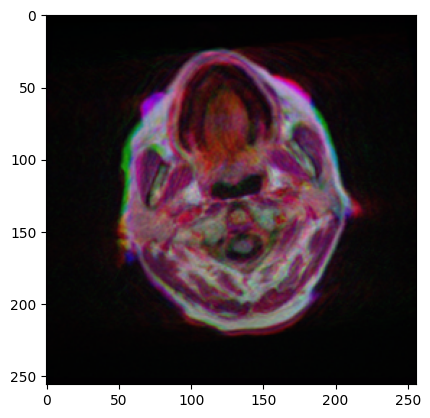

In [9]:

import cv2
plt.imshow(cv2.imread(brian_df['image_path'][82]))

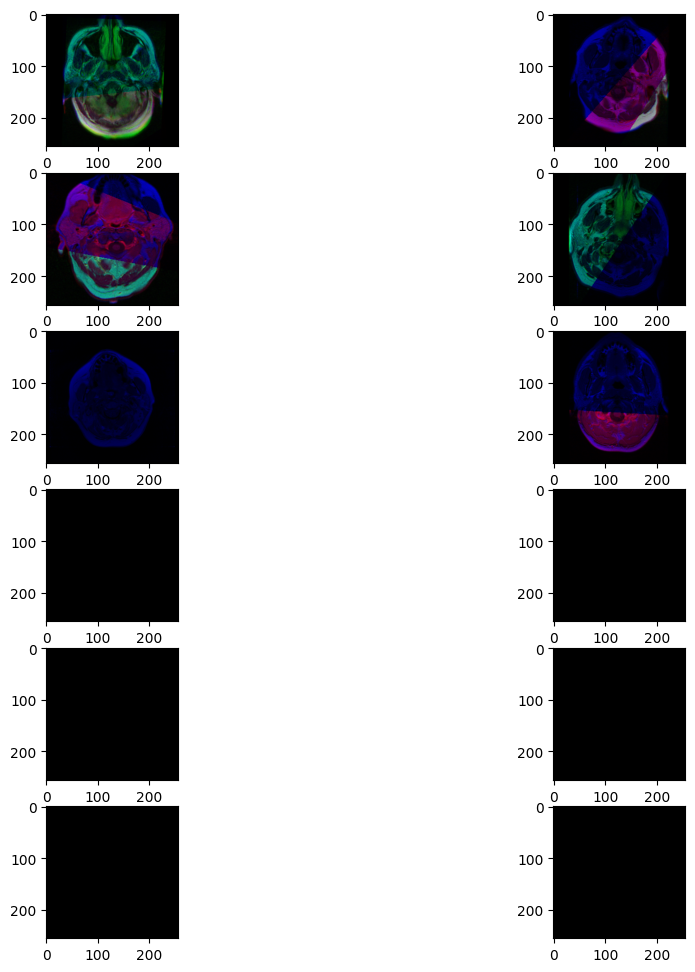

In [10]:


fig = plt.figure(figsize = (12,12))
for i in range(12):
  if(i < 6 ):
    fig.add_subplot(6,2, i+1)
    plt.imshow(cv2.imread(brian_df['image_path'][i]))
  if(i >= 6):
    fig.add_subplot(6,2, i+1)
    plt.imshow(cv2.imread(brian_df['mask_path'][i-6]))
fig.show()

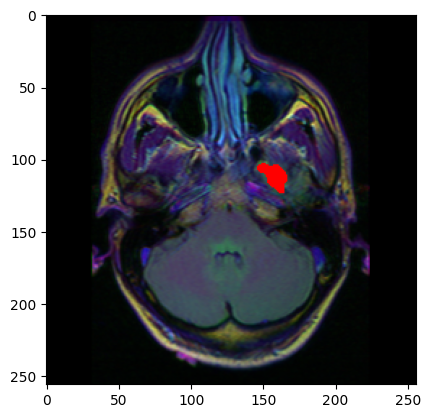

In [11]:
from skimage import io
i=445
img = io.imread(brian_df.image_path[i])
img2 = cv2.imread(brian_df.image_path[i])

mask = io.imread(brian_df.mask_path[i])
mask2 = cv2.imread(brian_df.mask_path[i])

mask2_gray = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY)
img[mask2_gray == 255] = (255, 0, 0) # Cambia el color de los píxeles en la imagen donde la máscara es 255
plt.imshow(img)

Dibuja la máscara en el cerebro

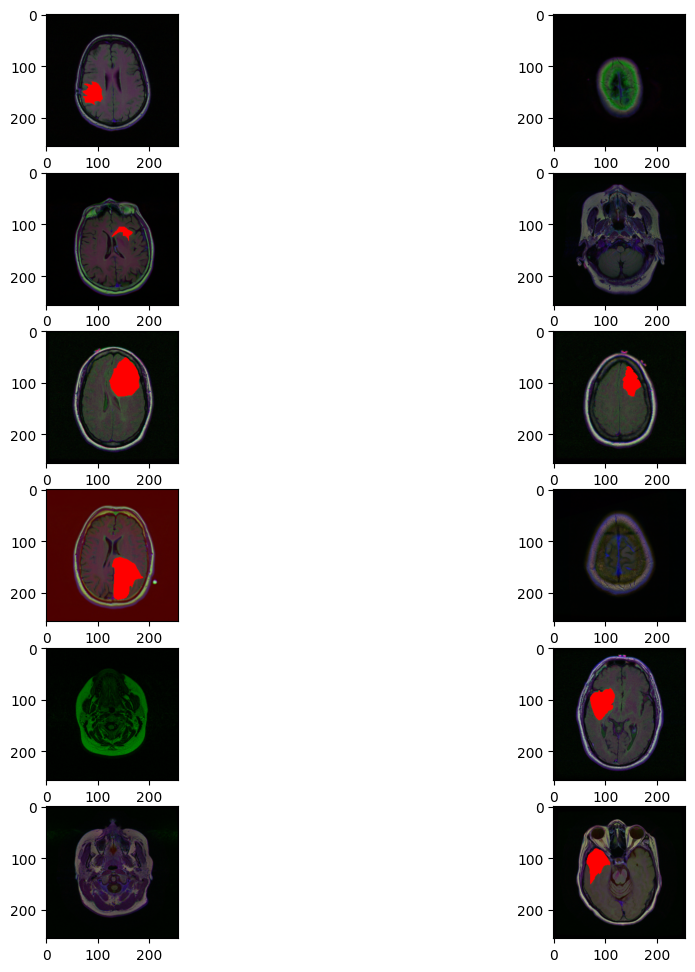

In [12]:
from skimage import io
fig = plt.figure(figsize=(12,12))
for i in range(12):
  randomplace = np.random.randint(len(brian_df)-1)
  img = io.imread(brian_df.image_path[randomplace])
  img2 = cv2.imread(brian_df.image_path[randomplace])
  mask = io.imread(brian_df.mask_path[randomplace])
  mask2 = cv2.imread(brian_df.mask_path[randomplace])
  mask2_gray = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY)
  img[mask2_gray == 255] = (255, 0, 0) # Cambia el color de los píxeles en la imagen donde la máscara es 255
  fig.add_subplot(6,2, i+1)
  plt.imshow(img)
fig.show()

In [13]:
brian_df['mask'] = brian_df['mask'].astype(str)

In [14]:
brian_df_train = brian_df.drop(columns = ['patient_id'])
brian_df_train.shape

(3929, 3)

In [15]:
brian_df_train = brian_df_train.drop('mask', 1)

<ipython-input-15-dc8b2e27fd94>:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [16]:
y = brian_df['mask']
y.shape

(3929,)

In [17]:
y = y.astype(str)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(brian_df_train,y, test_size = 0.15, shuffle=True)

In [19]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00


In [20]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [21]:
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)
train_generator=datagen.flow_from_dataframe(
dataframe=brian_df,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))
valid_generator=datagen.flow_from_dataframe(
dataframe=brian_df,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))
# Creamos un generador de datos para imágenes de prueba
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=brian_df,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 3340 validated image filenames belonging to 2 classes.
Found 589 validated image filenames belonging to 2 classes.
Found 3929 validated image filenames belonging to 2 classes.


In [22]:
from keras.applications import ResNet50
from keras import Input
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94765736/94765736 [==============================] - 1s 0us/step


In [23]:
for layer in basemodel.layers:
  layer.trainable = False

Para evitar que se actualicen los pesos conseguidos durante el preentrenamiento

In [24]:
from keras.layers import *
from keras import Model
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)
model = Model(inputs = basemodel.input, outputs = headmodel)

In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)
checkpointer = ModelCheckpoint(filepath = "/content/drive/MyDrive/PIA23-24/tema4/Brain_MRI/ModeloCerebero.hdf5", verbose = 1, save_best_only = True)


In [32]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [33]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n / 16 , epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n / 16, callbacks=[checkpointer, earlystopping])

209/208 [==============================] - ETA: -1s - loss: 0.7210 - accuracy: 0.5641
Epoch 1: val_loss improved from inf to 0.56681, saving model to /content/drive/MyDrive/PIA23-24/tema4/Brain_MRI/ModeloCerebero.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



208/208 [==============================] - 1805s 9s/step - loss: 0.7210 - accuracy: 0.5641 - val_loss: 0.5668 - val_accuracy: 0.9932


In [34]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

245/245 [==============================] - 918s 4s/step


In [35]:
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [37]:
original = np.asarray(brian_df['mask'])[:len(predict)]
len(original)

3920

In [38]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.6497448979591837

<Axes: >

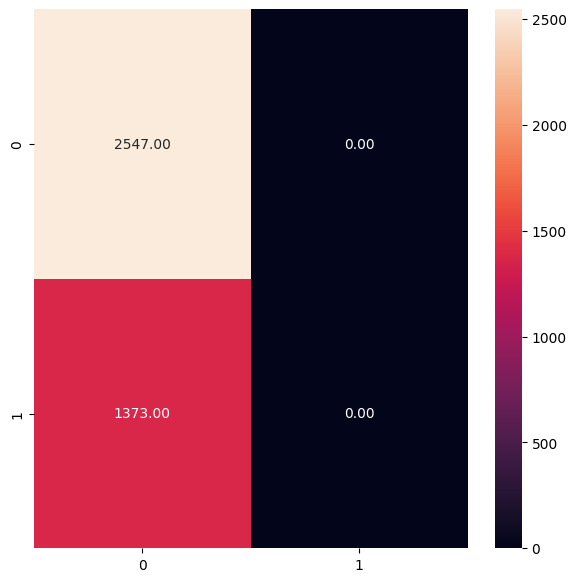

In [40]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, fmt = ".2f")

In [45]:
brain_df = pd.read_csv('/content/drive/MyDrive/PIA23-24/tema4/Brain_MRI/data_mask.csv')
brain_df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [47]:
# Obtenemos el dataframe que contiene las resonancias magnéticas que tienen máscaras asociadas.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [50]:
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [51]:
from utilities import DataGenerator

# Creamos los generadores de imágenes

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [52]:
def resblock(X, f):


  # Hacemos la copia de la entrada
  X_copy = X

  # Ruta principal
  # Más acerca de he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Ruta corta
  # Más sobre esto en: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

    # Agregar la salida de la ruta principal y la ruta corta juntas

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [53]:
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [54]:
input_shape = (256,256,3)

# Forma del tensor de entrada
X_input = Input(input_shape)

# Fase 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Fase 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Fase 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Fase 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Fase 5 (Cuello de Botella)
conv5_in = resblock(pool_4, 256)

# Fase de Escalada 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Fase de Escalada 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Fase de Escalada 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Fase de Escalada 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Salida Final
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [55]:
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['batch_normalization[0]

In [56]:
from utilities import focal_tversky, tversky_loss, tversky

In [57]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [58]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el mejor modelo con menor pérdida de validación
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/PIA23-24/tema4/Brain_MRI/ResUWeights.hdf5", verbose=1, save_best_only=True)

In [59]:
history = model_seg.fit(training_generator , epochs = 1, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

72/72 [==============================] - ETA: 0s - loss: 0.8785 - tversky: 0.1584 
Epoch 1: val_loss improved from inf to 0.80317, saving model to ResUNet-weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



72/72 [==============================] - 841s 11s/step - loss: 0.8785 - tversky: 0.1584 - val_loss: 0.8032 - val_tversky: 0.2533


In [60]:
model_json = model_seg.to_json()
with open("/content/drive/MyDrive/PIA23-24/tema4/Brain_MRI/ResUNet.json","w") as json_file:
  json_file.write(model_json)

In [62]:
from utilities import prediction

# Hacemos la predicción
image_id, mask, has_mask = prediction(X_test, model, model_seg)

1/1 [==============================] - 0s 365ms/step


In [63]:
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

,image_path,predicted_mask,has_mask
0,TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_15...,No mask,0
1,TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_40...,No mask,0
2,TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_12...,No mask,0
3,TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_12...,No mask,0
4,TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_15...,No mask,0
...,...,...,...
98,TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_29...,No mask,0
99,TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_16...,No mask,0
100,TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_9.tif,No mask,0
101,TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_18...,No mask,0


In [65]:
df_pred = X_test.merge(df_pred, on = 'image_path')
df_pred.head()

,patient_id,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_DU_A5TP_19970614,TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_15...,TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_15...,1,No mask,0
1,TCGA_HT_A61B_19991127,TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_40...,TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_40...,1,No mask,0
2,TCGA_DU_8163_19961119,TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_12...,TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_12...,1,No mask,0
3,TCGA_DU_7008_19830723,TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_12...,TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_12...,1,No mask,0
4,TCGA_DU_7302_19911203,TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_15...,TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_15...,1,No mask,0


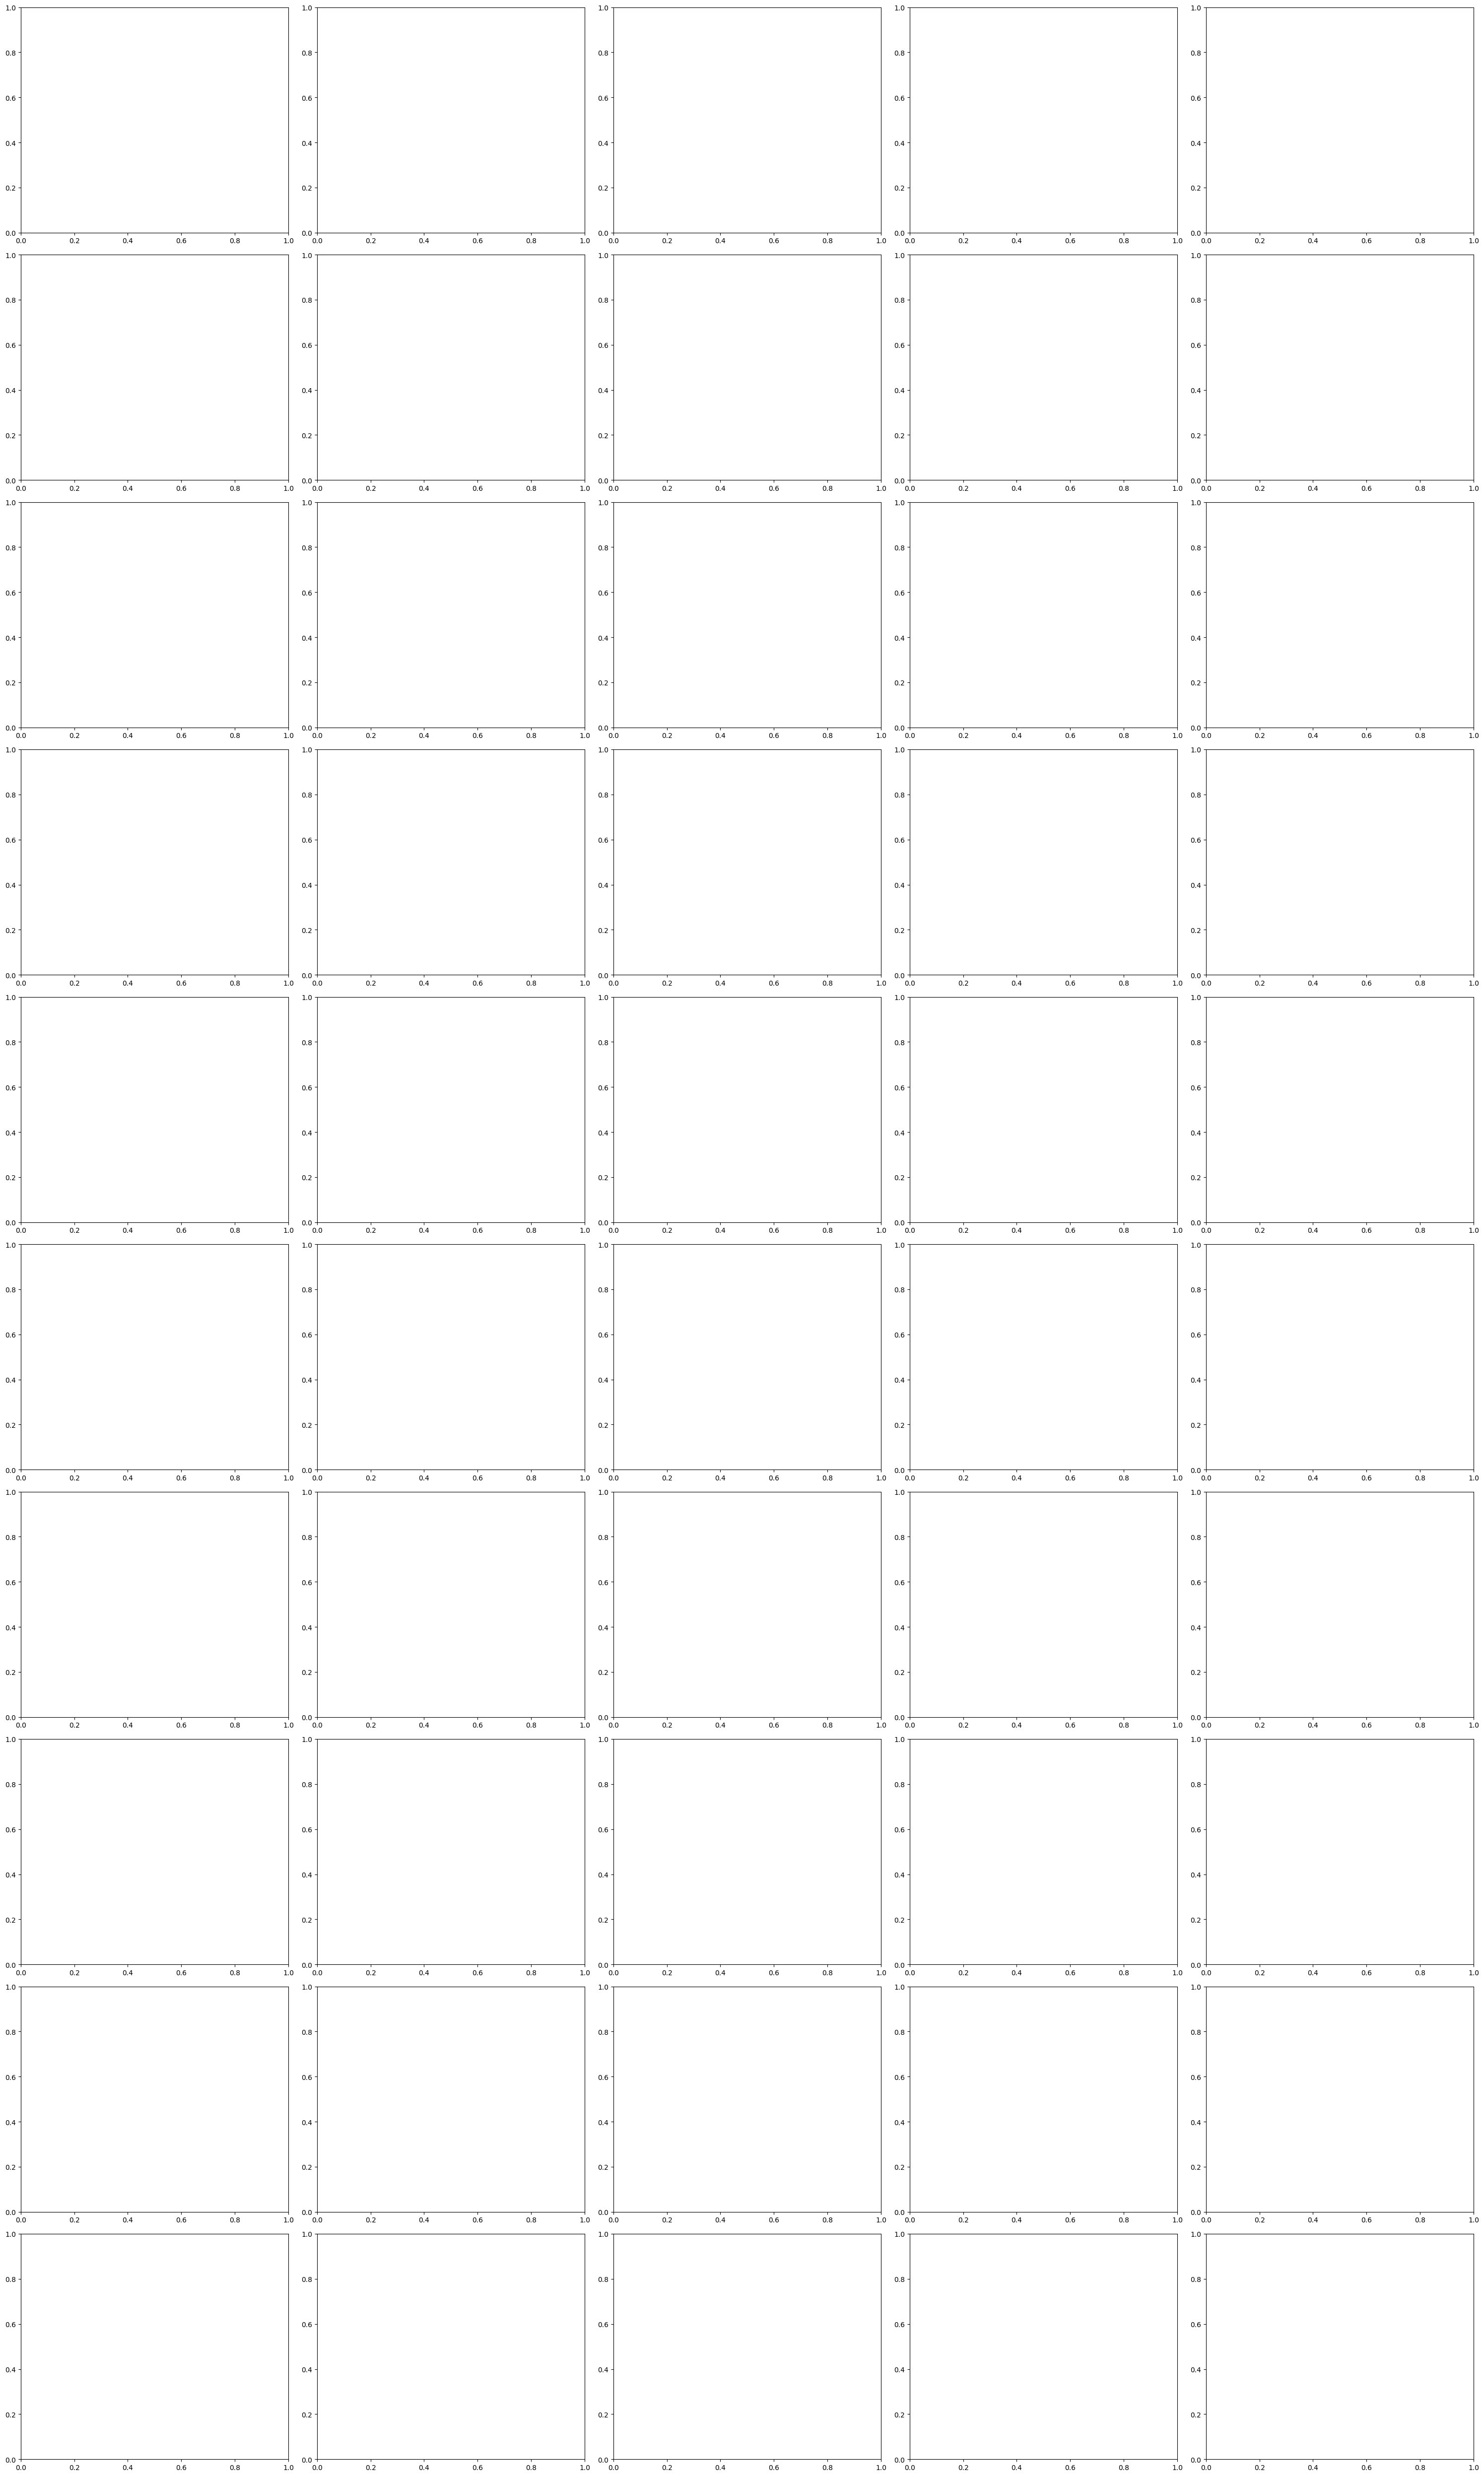

In [66]:
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # leer las imágenes y convertirlas a formato RGB
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("MRI del Cerebro")
    axs[count][0].imshow(img)

    # Obtenemos la máscara para la imagen
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Máscara Original")
    axs[count][1].imshow(mask)

    # Obtenemos la máscara de predicción para dicha imagen
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("Máscara predicha por la IA")
    axs[count][2].imshow(predicted_mask)

    # Aplicamos la máscara a la imagen 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI con la máscara original (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI con la máscara predicha por la IA")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()